In [57]:
import os
import sys
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mizani.formatters import percent_format
from plotnine import *
from datetime import datetime
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import norm
from IPython.core.display import HTML
from stargazer.stargazer import Stargazer
import statsmodels.nonparametric.kernel_regression as loess

from mizani.transforms import log_trans
from mizani.formatters import percent_format
from mizani.formatters import log_format

# 1.: Cleaning the dataframe

## Merge

In [58]:
# Read the CSVs into a variable
price_data = pd.read_csv('hotels-europe_price.csv')
features_data = pd.read_csv('hotels-europe_features.csv')

In [59]:
# merge the two datasets with the key 'hotel_id'
merged_hotel_data = pd.merge(price_data, features_data, on='hotel_id')

In [60]:
# filter the merged data for Moscow
merged_hotel_data_moscow = merged_hotel_data.loc[merged_hotel_data["city"] == "Moscow"]

## Ratings Data Cleaning

In [61]:
# Step 1: Identify the number of null values in the 'rating' column
null_count = merged_hotel_data_moscow['rating'].isnull().sum()
print(f"Number of null values in the 'rating' column: {null_count}")

Number of null values in the 'rating' column: 792


In [62]:
# Step 2: Transform null values to 0
merged_hotel_data_moscow['rating'].fillna('NULL', inplace=True)

C:\Users\Szabados\AppData\Local\Temp\ipykernel_8384\2179072277.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [63]:
# Optionally, verify the transformation
print(merged_hotel_data_moscow['rating'].isnull().sum())  # Should output 0

0


In [64]:
# Drop rows where 'rating_reviewcount' is 'NULL'
merged_hotel_data_moscow = merged_hotel_data_moscow[merged_hotel_data_moscow['rating'] != 'NULL']

# Optionally, verify the operation
print(f"Number of rows with 'rating' as 'NULL': {len(merged_hotel_data_moscow[merged_hotel_data_moscow['rating'] == 'NULL'])}")

Number of rows with 'rating' as 'NULL': 0


## `rating_reviewcount` cleaning

In [65]:
# Step 1: Identify the number of null values in the 'rating' column
null_count = merged_hotel_data_moscow['rating_reviewcount'].isnull().sum()
print(f"Number of null values in the 'rating' column: {null_count}")

Number of null values in the 'rating' column: 0


In [66]:
# Step 2: Transform null values to 0
merged_hotel_data_moscow['rating_reviewcount'].fillna('NULL', inplace=True)

In [67]:
# Optionally, verify the transformation
print(merged_hotel_data_moscow['rating_reviewcount'].isnull().sum())  # Should output 0

0


In [68]:
# Drop rows where 'rating_reviewcount' is 'NULL'
merged_hotel_data_moscow = merged_hotel_data_moscow[merged_hotel_data_moscow['rating_reviewcount'] != 'NULL']

# Optionally, verify the operation
print(f"Number of rows with 'rating_reviewcount' as 'NULL': {len(merged_hotel_data_moscow[merged_hotel_data_moscow['rating_reviewcount'] == 'NULL'])}")

Number of rows with 'rating_reviewcount' as 'NULL': 0


## Create `highly_rated` column

In [69]:
# new column 'highly_rated'
# Set to 1 if 'rating' is greater than or equal to 4, and 0 otherwise
merged_hotel_data_moscow['highly_rated'] = merged_hotel_data_moscow['rating'].apply(lambda x: 1 if x >= 4 else 0)
merged_hotel_data_moscow.head()

,hotel_id,price,offer,offer_cat,year,month,weekend,holiday,nnights,scarce_room,...,city_actual,rating_reviewcount,center1label,center2label,neighbourhood,ratingta,ratingta_count,distance_alter,accommodation_type,highly_rated
77578,10947,59,1,15-50% offer,2017,12,0,1,1,0,...,Moscow,240.0,City centre,Solntsevo Exhibition Hall,Alexeevsky,3.0,2351.0,15.0,Hotel,0
77579,10947,58,1,15-50% offer,2018,4,1,0,1,0,...,Moscow,240.0,City centre,Solntsevo Exhibition Hall,Alexeevsky,3.0,2351.0,15.0,Hotel,0
77580,10947,58,1,15-50% offer,2018,5,1,0,1,0,...,Moscow,240.0,City centre,Solntsevo Exhibition Hall,Alexeevsky,3.0,2351.0,15.0,Hotel,0
77581,10947,231,1,15-50% offer,2017,12,0,1,4,0,...,Moscow,240.0,City centre,Solntsevo Exhibition Hall,Alexeevsky,3.0,2351.0,15.0,Hotel,0
77582,10947,81,0,0% no offer,2017,11,0,0,1,0,...,Moscow,240.0,City centre,Solntsevo Exhibition Hall,Alexeevsky,3.0,2351.0,15.0,Hotel,0


## Basic OLS Regression

In [70]:
# Assuming 'merged_hotel_data' is your DataFrame
# Selecting some potential independent variables (adjust as needed)
X = merged_hotel_data_moscow[['price', 'stars', 'distance']]  # Example features
y = merged_hotel_data_moscow['highly_rated']  # Dependent variable

# Adding a constant to the model (intercept)
X = sm.add_constant(X)

# Building the OLS model
model = sm.OLS(y, X).fit()

# Printing the summary of the model
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:           highly_rated   R-squared:                       0.130
Model:                            OLS   Adj. R-squared:                  0.129
Method:                 Least Squares   F-statistic:                     127.6
Date:                Sun, 03 Dec 2023   Prob (F-statistic):           5.24e-77
Time:                        22:16:21   Log-Likelihood:                -1554.0
No. Observations:                2566   AIC:                             3116.
Df Residuals:                    2562   BIC:                             3139.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0813      0.032      2.545      0.0

# Part 2

### **Estimate with distance and stars as explanatory variables**:
- linear probability models
- logit models
- probit models

*You may add other variables if you wish*.

### **Compare**:
- Coefficients
- Marginal differences
- Predicted probabilities

Discuss your results!

## Linear Probability Models

In [71]:
lpm1 = smf.ols(
    "highly_rated ~ price + stars + distance",
    merged_hotel_data_moscow,
).fit(covtype="HC1")

In [72]:
stargazer = Stargazer([lpm1])
stargazer.covariate_order(
    [
        "price",
        "stars",
        "distance",
    ]
)
stargazer.rename_covariates({"Intercept": "Constant"})
stargazer.add_line("Offer indicators", ["Yes"])
stargazer


In [73]:
merged_hotel_data_moscow["pred_lpm"] = lpm1.predict()
merged_hotel_data_moscow["pred_lpm"].describe().round(4)

count    2566.0000
mean        0.6551
std         0.1714
min         0.2487
25%         0.5736
50%         0.6289
75%         0.7580
max         1.4228
Name: pred_lpm, dtype: float64

c:\Users\Szabados\anaconda3\Lib\site-packages\plotnine\layer.py:284: PlotnineWarning: stat_bin : Removed 37 rows containing non-finite values.


c:\Users\Szabados\anaconda3\Lib\site-packages\plotnine\layer.py:364: PlotnineWarning: geom_histogram : Removed 4 rows containing missing values.


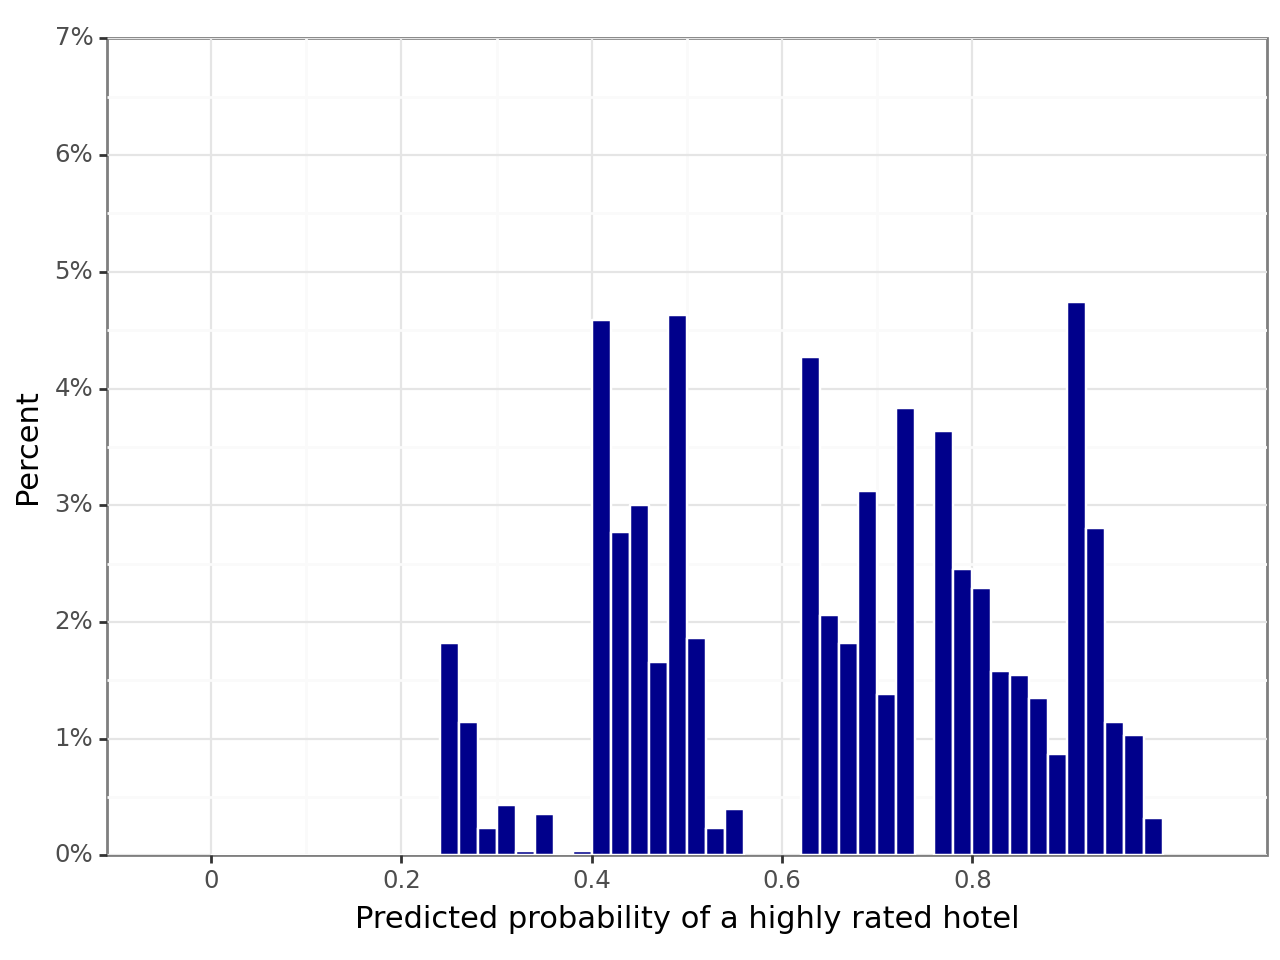

<Figure Size: (640 x 480)>

In [74]:
g1 = (
    ggplot(merged_hotel_data_moscow, aes(x="pred_lpm"))
    + geom_histogram(
        aes(y="stat(count)/sum(stat(count))"),
        binwidth=0.02,
        center=0.65,
        color="white",
        fill="darkblue",
        closed="right",
    )
    + labs(x="Predicted probability of a highly rated hotel", y="Percent")
    + scale_y_continuous(
        expand=[0.00, 0.0],
        limits=[0, 0.07],
        breaks=np.arange(0, 0.07, 0.01),
        labels=percent_format(),
    )
    + scale_x_continuous(expand=[0.1, 0.01], limits=[0, 1], breaks=np.arange(0, 1, 0.2))
    + theme_bw()
)
g1


In [75]:
cuts = 100
merged_hotel_data_moscow["q100_pred_lpm"] = pd.qcut(merged_hotel_data_moscow["pred_lpm"], q=cuts, labels=range(1, cuts + 1))

merged_hotel_data_moscow.loc[
    merged_hotel_data_moscow["q100_pred_lpm"] == 1,
    [
        "price",
        "stars",
        "distance"
    ],
].describe().round(1)

# Bottom 1%

,price,stars,distance
count,28.0,28.0,28.0
mean,31.2,1.0,0.7
std,6.1,0.0,0.2
min,19.0,1.0,0.5
25%,28.0,1.0,0.5
50%,29.0,1.0,0.5
75%,35.2,1.0,1.0
max,48.0,1.0,1.0


In [76]:
merged_hotel_data_moscow.loc[
    merged_hotel_data_moscow["q100_pred_lpm"] == 100,
    [
        "price",
        "stars",
        "distance"
    ],
].describe().round(1)

# Top 1%

,price,stars,distance
count,22.0,22.0,22.0
mean,1076.2,5.0,6.9
std,568.5,0.0,6.9
min,432.0,5.0,0.0
25%,617.0,5.0,0.5
50%,1058.0,5.0,2.0
75%,1224.2,5.0,14.0
max,2471.0,5.0,16.0
